MODEL HIGHLIGHTS:

•	Automated univariate and multivariate/parallel time series implementation

•	Ability to handle messy data by learning optimal NaN imputation (lead and lag backward forward filled + IterativeImputer)

•	Feature Selection + linear and nonlinear feature reduction (SelectKBest, PCA, umap) 

•	Optimal periodicity searching for the LSTM model (Power Spectral Density)

•	LSTM for forecasting


This project aims to guide enterprise stakeholders in their future business decisions. The users can upload several datasets and choose the target subjects, target variables, and requested prediction interval.

It will bring the following for its users:

•	the predictions for the target subjects and variables,

•	data insights related to target subjects and target variables,

•	a combined dataset that all missing entries are imputed.

We use the GDP forecast example to demonstrate how automated data analysis can be done and what values it will bring to the users.


DATASET:

2019 dataset from across 13 publicly available sources. (15312 observations, 3451 variables, 403.2MB memory usage, 196 countries observed for 58 years)
1.	World Bank Development Indicators (https://datacatalog.worldbank.org/dataset/world-development-indicators)
2.	Penn World tables (https://www.rug.nl/ggdc/productivity/pwt/?lang=en)
3.	Global competitiveness indices (https://govdata360.worldbank.org/indicators/h93b3b7a4)
4.	Global competitiveness report (https://www.weforum.org/reports/how-to-end-a-decade-of-lost-productivity-growth)
5.	World governance indicators (https://info.worldbank.org/governance/wgi/)
6.	IMF World economic outlook (https://www.imf.org/en/Publications/SPROLLs/world-economic-outlook-databases)
7.	Atlas of Economic complexity (https://atlas.cid.harvard.edu/)
8.	Reinhart and Rogoff FX (https://www.ilzetzki.com/irr-data)
9.	Barro-Lee education data (http://www.barrolee.com/)
10.	Enterprise survey (https://www.enterprisesurveys.org/en/enterprisesurveys)
11.	Doing business indicators (DBI) (https://www.doingbusiness.org/en/data)
12.	Economist intelligence unit (https://country.eiu.com/united-states)
13.	Quality of government (https://www.gu.se/en/quality-government/qog-data)

Link to Jupyter Notebook: https://github.com/haydarevren/automated-insight-capstone/blob/main/automated-insight.ipynb

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import jupyter 
import voila

# from collections import defaultdict
# from sklearn.preprocessing import LabelEncoder

# from sklearn.preprocessing import MinMaxScaler

# from sklearn.experimental import enable_iterative_imputer 
# from sklearn.impute import IterativeImputer
# from sklearn.linear_model import BayesianRidge

# import umap

# from scipy import fftpack
# from sklearn.metrics import mean_squared_error

In [198]:
#user inputs
subject_iden_col=['iso']
time_iden_cols=['year']
target_cols=['WB_ny_gdp_mktp_cd']
target_subjects=['USA', 'OED']
target_periods=3

# #user datasets
# df1=pd.read_csv('data/dataset1.csv', index_col=subject_iden_col+time_iden_cols)
# df2=pd.read_csv('data/dataset2.csv', index_col=subject_iden_col+time_iden_cols)
# df3=pd.read_csv('data/dataset3.csv', index_col=subject_iden_col+time_iden_cols)
# df4=pd.read_csv('data/dataset4.csv', index_col=subject_iden_col+time_iden_cols)
# df5=pd.read_csv('data/dataset5.csv', index_col=subject_iden_col+time_iden_cols)
# df6=pd.read_csv('data/dataset6.csv', index_col=subject_iden_col+time_iden_cols)
# df7=pd.read_csv('data/dataset7.csv', index_col=subject_iden_col+time_iden_cols)

In [199]:
# df=pd.concat([df1,df2,df3,df4,df5,df6,df7],axis=1).reset_index()

Data Set (first 5 observations):

In [200]:
ds1=pd.read_csv('data/ds1.csv')
ds1.head(5)

,iso,year,countrycode,countryname,regionname,adminregion,adminregionname,incomelevel,incomelevelname,lendingtype,...,QG_wdi_unempfilo,QG_wdi_unempilo,QG_wdi_unempmilo,QG_wdi_unempyfilo,QG_wdi_unempyilo,QG_wdi_unempymilo,QG_wdi_wip,QG_who_sanittot,QG_whr_hap,QG_wr_regtype
0,ABW,1961,ABW,Aruba,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABW,1962,ABW,Aruba,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABW,1963,ABW,Aruba,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABW,1964,ABW,Aruba,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABW,1965,ABW,Aruba,Latin America and Caribbean,NaN,NaN,HIC,High income,LNX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [201]:
# df.head(10)

Information about dataset:

In [202]:
print("<class 'pandas.core.frame.DataFrame'>\nRangeIndex: 15312 entries, 0 to 15311 \nColumns: 3451 entries, iso to QG_wr_regtype\ndtypes: float64(3398), int64(1), object(52)\nmemory usage: 403.2+ MB")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15312 entries, 0 to 15311 
Columns: 3451 entries, iso to QG_wr_regtype
dtypes: float64(3398), int64(1), object(52)
memory usage: 403.2+ MB


In [203]:
# df.info(verbose=0)

In [204]:
print('Target subjects are : %s' %(target_subjects))

Target subjects are : ['USA', 'OED']


In [205]:
print('Forecast for next %d periods.' %(target_periods))

Forecast for next 3 periods.


In [206]:
data_info = pd.read_csv('data/features_dictionary.csv')

In [207]:
def feat_info(cols: list) :
    return data_info[data_info['Identifier'].isin(cols)]

Target Columns:

In [208]:
feat_info(target_cols)

,Identifier,Description,Source,Publisher,Year,Topic
306,WB_ny_gdp_mktp_cd,GDP (current US$),World Development Indicators,The World Bank Group,2018,Economic Growth


In [209]:
# high_missing_cols =list(df.columns[(df.isna().sum()/len(df))>0.8]) #columns that more than 80% off entries missing 

# df=df.drop(columns=high_missing_cols)

In [123]:
# df['subject']=df[subject_iden_col]
# df=df.drop(columns=subject_iden_col)

# df['date'] =df[time_iden_cols]
# df=df.drop(columns=time_iden_cols)

# df['SUBJECT']=df['subject']
# df['DATE']=df['date']

In [124]:
# cat_cols=list(df.drop(['SUBJECT'],axis=1).select_dtypes(exclude=[np.float,np.int64]).columns)
# num_cols=list(df.drop(['DATE']+target_cols,axis=1).select_dtypes(include=[np.float,np.int64]).columns)

# df=df[['SUBJECT', 'DATE'] + target_cols + num_cols + cat_cols]

Before imputation dataset looks like:

In [125]:
# df.tail(10)

In [130]:
ds3=pd.read_csv('data/ds3.csv', index_col='Unnamed: 0')
ds3.tail(5)

,SUBJECT,DATE,WB_ny_gdp_mktp_cd,WB_ny_gdp_defl_kd_zg,WB_ag_agr_trac_no,WB_ag_lnd_agri_k2,WB_ag_lnd_agri_zs,WB_ag_lnd_arbl_ha,WB_ag_lnd_arbl_ha_pc,WB_ag_lnd_arbl_zs,...,QG_iaep_cc,QG_iaep_epmf,QG_iaep_es,QG_iaep_osp,QG_iaep_ufs,QG_lp_legor,QG_no_ef,QG_no_ufs,QG_wr_regtype,subject
15307,ZWE,2014,1.949552e+10,-0.252141,NaN,162000.0,41.876696,4000000.0,0.294406,10.339925,...,NaN,NaN,NaN,NaN,NaN,1. English Common Law,NaN,NaN,NaN,ZWE
15308,ZWE,2015,1.996312e+10,0.607814,NaN,162000.0,41.876696,4000000.0,0.289548,10.339925,...,NaN,NaN,NaN,NaN,NaN,1. English Common Law,NaN,NaN,NaN,ZWE
15309,ZWE,2016,2.054868e+10,2.160993,NaN,162000.0,41.876696,4000000.0,0.285095,10.339925,...,NaN,NaN,NaN,NaN,NaN,1. English Common Law,NaN,NaN,NaN,ZWE
15310,ZWE,2017,2.281301e+10,6.031593,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1. English Common Law,NaN,NaN,NaN,ZWE
15311,ZWE,2018,3.100052e+10,28.005545,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1. English Common Law,NaN,NaN,NaN,ZWE


# PART 1

# IMPUTATION

Let's fill the missing values. We first encode the categorical values, then scale the dataset. 
Two-stage imputer:

1-) Create lag and lead terms and backward and forward fill them.

2-) Use the information from previous and later period and 5 nearest features to fill the missing values by Bayesian Ridge Imputer. (the imputation for categorical variables restricted such that they do not go outside their bounds)

In [136]:
# scaled_df_lag_lead=gen_lag_lead(scaled_df,n_in=1,n_out=1,dropnan=False).drop(columns=['SUBJECT', 'DATE'])

In [137]:
# imputer = IterativeImputer(BayesianRidge(),n_nearest_features=3,tol=0.01,verbose=0,min_value=-0.001,max_value=1.001)
# imputed_data=imputer.fit_transform(scaled_df_lag_lead)

In [138]:
# imputed_data=pd.DataFrame(data=imputed_data, columns=scaled_df_lag_lead.columns, index=scaled_df_lag_lead.index)

In [139]:
# imputed_scaled_df_lag_lead=imputed_data

# imputed_scaled_df=imputed_data[scaled_df.drop(columns=['SUBJECT', 'DATE']).columns]


In [140]:
# imputed_encoded_df=scaler.inverse_transform(imputed_scaled_df)

In [141]:
# imputed_encoded_df=pd.DataFrame(data=imputed_encoded_df,columns=df.drop(columns=['SUBJECT','DATE']).columns,index=df.index)

In [142]:
# imputed_df=imputed_encoded_df
# imputed_df[cat_cols]=imputed_df[cat_cols].apply(lambda x: np.rint(x)).astype(np.int64)

# imputed_df[cat_cols] = imputed_df[cat_cols].apply(lambda x: dic_encoder[x.name].inverse_transform(x))

In [143]:
# imputed_df['SUBJECT']=df['SUBJECT']
# imputed_df['DATE']=df['DATE']
# imputed_df=imputed_df[['SUBJECT', 'DATE'] + target_cols + num_cols + cat_cols]

Final imputed dataset:

In [144]:
# imputed_df.tail(10)

In [145]:
ds4=pd.read_csv('data/ds4.csv', index_col='Unnamed: 0')
ds4.tail(5)

,SUBJECT,DATE,WB_ny_gdp_mktp_cd,WB_ny_gdp_defl_kd_zg,WB_ag_agr_trac_no,WB_ag_lnd_agri_k2,WB_ag_lnd_agri_zs,WB_ag_lnd_arbl_ha,WB_ag_lnd_arbl_ha_pc,WB_ag_lnd_arbl_zs,...,QG_iaep_cc,QG_iaep_epmf,QG_iaep_es,QG_iaep_osp,QG_iaep_ufs,QG_lp_legor,QG_no_ef,QG_no_ufs,QG_wr_regtype,subject
15307,ZWE,2014,1.949552e+10,-0.252141,208766.579968,162000.000000,41.876696,4.000000e+06,0.294406,10.339925,...,Yes,No,N/A - no legislature,No,Missing information,1. English Common Law,No competative elections,Unitary,Party-Military,ZWE
15308,ZWE,2015,1.996312e+10,0.607814,201445.771178,162000.000000,41.876696,4.000000e+06,0.289548,10.339925,...,Yes,No,N/A - no legislature,No,Missing information,1. English Common Law,No competative elections,Unitary,Party-Military,ZWE
15309,ZWE,2016,2.054868e+10,2.160993,191127.072674,162000.000000,41.876696,4.000000e+06,0.285095,10.339925,...,Yes,No,N/A - no legislature,No,Missing information,1. English Common Law,No competative elections,Unitary,Party-Military-Personal,ZWE
15310,ZWE,2017,2.281301e+10,6.031593,186700.549043,115983.303187,38.784419,2.737998e+06,0.217196,11.999161,...,Yes,No,N/A - no elected legislature,No,Missing information,1. English Common Law,No competative elections,Unitary,Party-Military-Personal,ZWE
15311,ZWE,2018,3.100052e+10,28.005545,201733.979566,884478.016527,38.090632,2.648727e+06,0.260472,12.068284,...,Yes,No,N/A - no elected legislature,No,Missing information,1. English Common Law,No competative elections,Unitary,Party,ZWE


# PART2

# PREPROCESS

We deploy a feature selection then two dimensionality reduction techniques to use in model construction.

Having irrelevant features in your data can decrease the accuracy of the models and make your model learn based on irrelevant features.

When dealing with high dimensional data, it is often useful to reduce the dimensionality by projecting the data to a lower dimensional subspace which captures the “essence” of the data.

We select the best 30 lead indicators according to F-value. (SelectKBest(f_regression, k=30) where target variables shifted by one period.)

We utilize the PCA linear dimensionality reduction of the best features to project it to a lower dimensional space.

We utilize the UMAP nonlinear dimension reduction technique. It is very similar to t-SNE but is very general non-linear dimension reduction and faster than t-SNE. It can accommodate both local and global properties. 

There are many different dimensionality reduction algorithms and no single best method for all datasets. Although, PCA tends to find linear correlations between variables, which is sometimes undesirable. We utilize two different technique to cover a lot of ground.

Dataset after dimension reduction:

In [152]:
# reduced_df.head()

In [212]:
ds5=pd.read_csv('data/ds5.csv', index_col='Unnamed: 0')
ds5.head()

,SUBJECT,DATE,WB_ny_gdp_mktp_cd,subject,date,umap0,umap1,umap2,pca0,pca1,pca2
0,ABW,1961,5.664328e+11,0,1961.0,7.673544,-3.309184,2.740360,-0.042787,0.001981,0.000146
1,ABW,1962,3.055660e+11,0,1962.0,7.584056,-3.149572,2.853826,-0.045854,0.002245,0.000075
2,ABW,1963,3.202148e+11,0,1963.0,7.560796,-3.199496,2.810458,-0.045376,0.002307,0.000096
3,ABW,1964,3.299147e+11,0,1964.0,7.589560,-3.145691,2.858384,-0.045516,0.002461,0.000119
4,ABW,1965,3.488399e+11,0,1965.0,7.580264,-3.185156,2.824124,-0.044894,0.002401,0.000023


Let's find whether there is a meaningful periodicity in the dataset

In [154]:
# ft_targets = fftpack.fft(reduced_df[target_cols], axis=0)
# frequencies = fftpack.fftfreq(reduced_df[target_cols].shape[0],1)
# periods = 1 / frequencies

# periodicity_find=pd.DataFrame(abs(ft_targets) * 1e-3,columns=target_cols)
# periodicity_find['periods']=periods

# fig9=plt.figure(figsize=(5,5))


# plt.plot(periodicity_find['periods'], periodicity_find[target_cols], 'o')
# plt.xlim(1, 50)
# plt.xlabel('Period')
# plt.ylabel('Power ($\cdot10^3$)')

# plt.show()

# pickle.dump(fig9, open('FigureObject9.fig.pickle', 'wb')) 

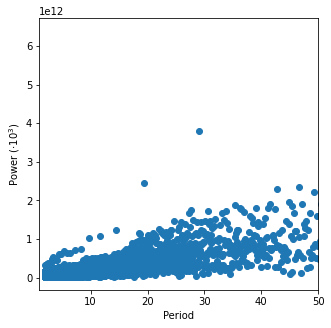

In [161]:
fig9 = pickle.load(open('FigureObject9.fig.pickle', 'rb'))

In [162]:
# periodicity_find[((periodicity_find['periods']>0) & (periodicity_find['periods']<50))].max()

In [163]:
# periodicity_find[((periodicity_find['periods']>0) & (periodicity_find['periods']<50))].idxmax()

In [164]:
# opt_period=np.rint(periodicity_find.loc[528,'periods'])

In [165]:
# #time constant t_r=0.35*period
# t_r=opt_period*0.35

In [166]:
print('Time constant is equal to 10 (highest period in the power spectrum times 0.35)')

Time constant is equal to 10 (highest period in the power spectrum times 0.35)


In [167]:
# window=np.rint(t_r/2).astype(np.int64)

In [168]:
print('Optimal window length is 5 (approximately half of the time constant)')

Optimal window length is 5 (approximately half of the time constant)


# PART 3

# First train the model for nontarget subjects (Rest of the World)

There are two ways to solve time-series panel data: either loop throughout the model for each country’s data or the countries’ panel data once. If you try both and obtain the RMSE for each way, you can compare the result and choose the best way for your time series panel data.

Let's first train the LSTM model with Global Dataset

In [169]:
#SCALE FEATURES 

In [170]:
# s=MinMaxScaler()
# Xs=s.fit_transform(reduced_df.drop(columns=['SUBJECT','DATE']))
# Ys=Xs

In [171]:
# X=[]
# Y=[]

In [172]:
# subject_lists=reduced_df['SUBJECT'].unique().tolist()

# subject_range_list=[]

# for subject in subject_lists:
#     range_subject=reduced_df.index[reduced_df['SUBJECT']==subject].tolist()
    
#     if not subject in target_subjects:
#         start=range_subject[0]
#         end=range_subject[-1]
        
#         for i in range(start+window,end+1):
#             X.append(Xs[i-window:i,:])
#             Y.append(Ys[i])
#             subject_range_list.append(i)

In [173]:
# X, Y =np.array(X), np.array(Y)

In [174]:
# model = Sequential()

# model.add(LSTM(units=32*Y.shape[1], activation='relu',input_shape=(X.shape[1], X.shape[2]), return_sequences=True ))
# model.add(Dropout(0.1))

# model.add(LSTM(units=8*Y.shape[1],return_sequences=False))
# model.add(Dropout(0.1))

# model.add(Dense(Y.shape[1]))
# model.add(Activation("linear"))

# model.compile(optimizer="adam",
#               loss='mse',
#               loss_weights=[1,0.001,0.001,0.01,0.00001,0.00001,0.00001,0.00001,0.00001]
#              )

# t0=time.time()

# model.fit(X,Y, 
#           epochs=30, 
#           batch_size=128,  verbose=0, shuffle=False,
#          )
        
# t1=time.time()
# t=t1-t0

Model loss in each epoch

In [177]:
# # plot history
# model_loss = pd.DataFrame(model.history.history)
# model_loss.plot()

In [178]:
# fig=model_loss.plot()
# pickle.dump(fig, open('FigureObject.fig.pickle', 'wb')) 

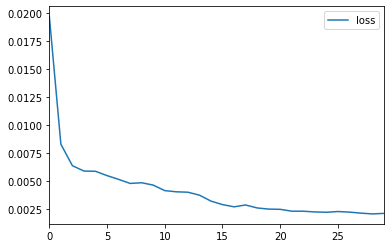

In [179]:
fig1 = pickle.load(open('FigureObject.fig.pickle', 'rb'))

# Model Evaluation (Rest of The World)

In [180]:
# Y_pred=model.predict(X)
# Y_pred=s.inverse_transform(Y_pred)
# Y_pred=pd.DataFrame(Y_pred,index=subject_range_list, columns=reduced_df.drop(columns=['SUBJECT','DATE']).columns)
# Y_pred['SUBJECT']=reduced_df.loc[subject_range_list]['SUBJECT']
# Y_pred['DATE']=reduced_df.loc[subject_range_list]['DATE']
# Y_pred=Y_pred[reduced_df.columns]
# Y=reduced_df.loc[subject_range_list]

How model performed for total for Rest of The World:

In [181]:
# fig2=plt.figure(figsize=(20,10))
# Y_pred.groupby('DATE')[target_cols[0]].mean().plot(kind='line',label='mean prediction',color='red',alpha=1)
# Y.groupby('DATE')[target_cols[0]].mean().plot(kind='line',label='mean actual values',color='blue',alpha=0.4)
# plt.xticks(rotation=90,size=20)
# plt.yticks(size=20)

# plt.ylabel(target_cols[0],fontsize=20)
# plt.xlabel('Date',fontsize=20)
# plt.title('Predicted Values VS Actual Values - Mean ',fontsize=20)
# plt.legend()



# pickle.dump(fig2, open('FigureObject2.fig.pickle', 'wb')) 


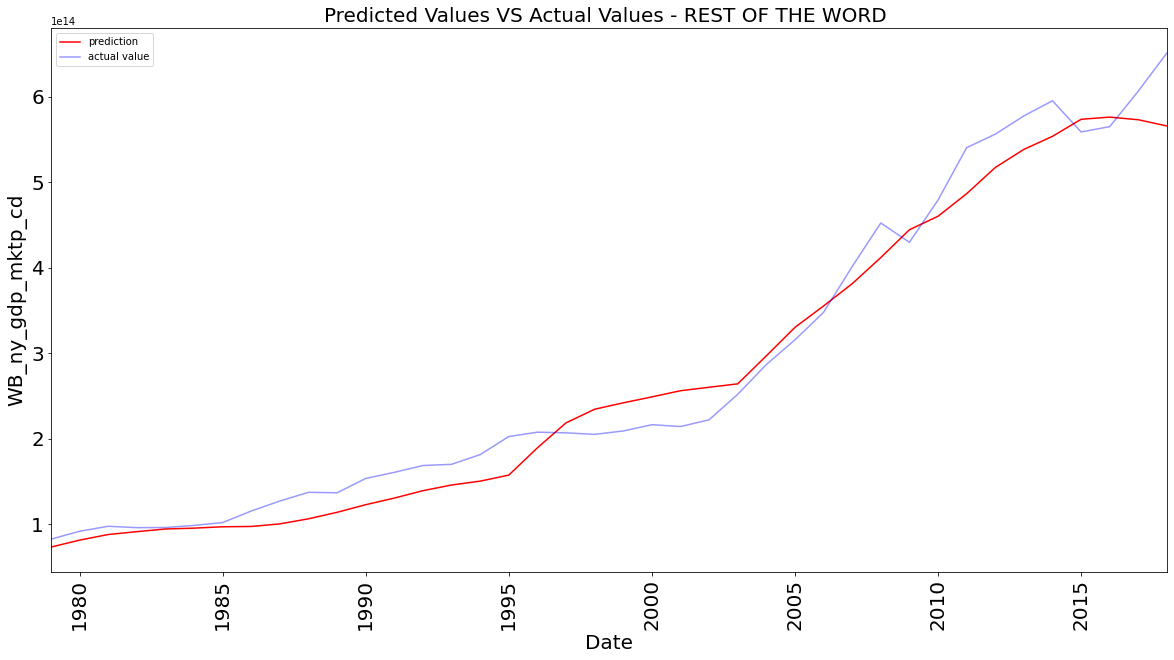

In [213]:
fig2 = pickle.load(open('FigureObject2.fig.pickle', 'rb'))

In [183]:
def RMSE(actual,prediction):
    rmse = np.sqrt(mean_squared_error(actual,prediction))
    return rmse

In [184]:
# print('RMSE is %d' %RMSE(Y[target_cols[0]],Y_pred[target_cols[0]]))

In [185]:
# print('RMSE is 850605668912')

# BACKTESTING TARGET COUNTRIES

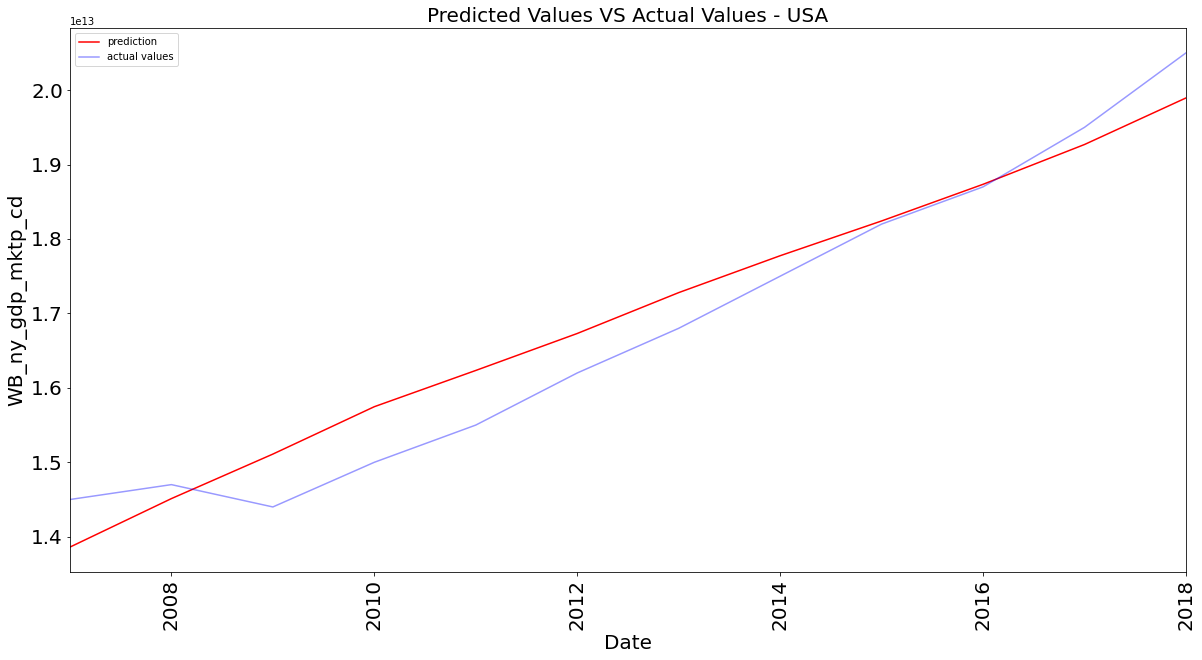

In [186]:
fig3 = pickle.load(open('FigureObject3.fig.pickle', 'rb'))

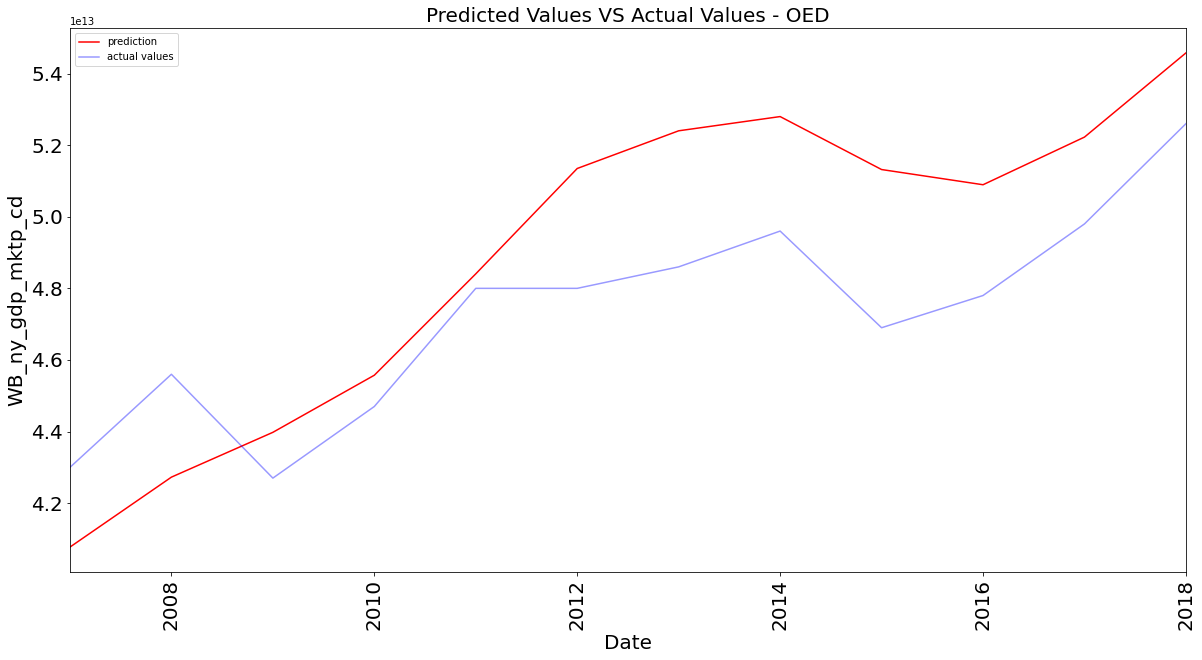

In [187]:
fig4 = pickle.load(open('FigureObject4.fig.pickle', 'rb'))

The plot shows the predicted values versus actual values.

# FORECAST

We forecast next 3 periods for each target county.

In [189]:
# #First fit model for test data then create a forcast for next periods

# for i, subject in enumerate(target_subjects):
#     X_train, Y_train, X_test, Y_test, subject_test_range_list = train_test_split(subject)
    
#     t0=time.time()
#     model.fit(X_test,Y_test, 
#               epochs=60, 
#               batch_size=16,  verbose=0, shuffle=False,
#              ) 

In [190]:
#Using predicted values to predict next step

In [191]:
# names=[]
# names.append('FigureObject6.fig.pickle')
# names.append('FigureObject7.fig.pickle')
# names.append('FigureObject8.fig.pickle')

In [192]:
# for i, subject in enumerate(target_subjects):
    
#     Yf=[]
#     range_subject=reduced_df.index[reduced_df['SUBJECT']==subject].tolist()
    
#     start=range_subject[-1]
    
#     X=Xs[start+1-window:start+1,:].copy()
#     for j in range(window,window+target_periods):
#         Xin=X[j-window:j].reshape((1,window,-1))
#         X=np.append(X,model.predict(Xin)).reshape((-1,9))
#         Yf.append(X[-1])
    
#     Yf=s.inverse_transform(Yf)
    
#     Yf=pd.DataFrame(Yf, columns=reduced_df.drop(columns=['SUBJECT','DATE']).columns)
#     Yf['SUBJECT']=reduced_df.loc[start]['SUBJECT']
#     Yf['DATE']=range(reduced_df.loc[start]['DATE']+1,reduced_df.loc[start]['DATE']+1+target_periods)
    
        
#     fig=plt.figure(figsize=(5,5))
#     Yf.groupby('DATE')[target_cols[0]].mean().plot(kind='line',label='forecast',color='red',alpha=1)
#     plt.xticks(Yf['DATE'],rotation=90,size=15)
#     plt.yticks(size=15)
    
    
#     plt.ylabel(target_cols[0],fontsize=15)
#     plt.xlabel('Date',fontsize=15)
#     plt.title('Forecast Values - %s' %(subject),fontsize=20)
#     plt.legend()  
    
#     pickle.dump(fig, open(names[i], 'wb'))

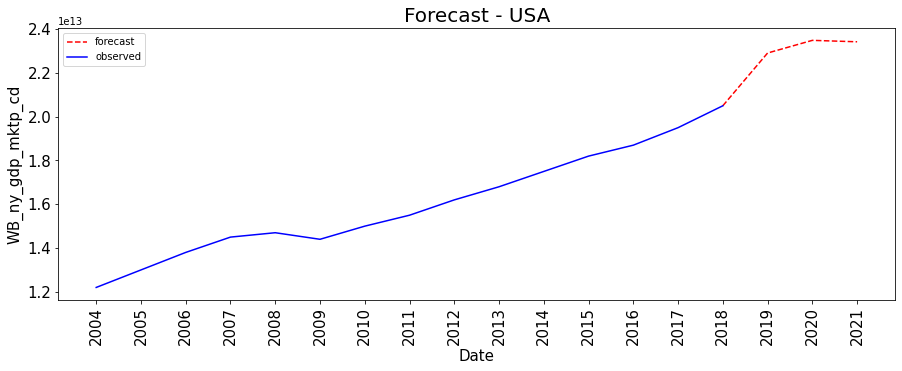

In [193]:
fig6 = pickle.load(open('FigureObject6.fig.pickle', 'rb'))

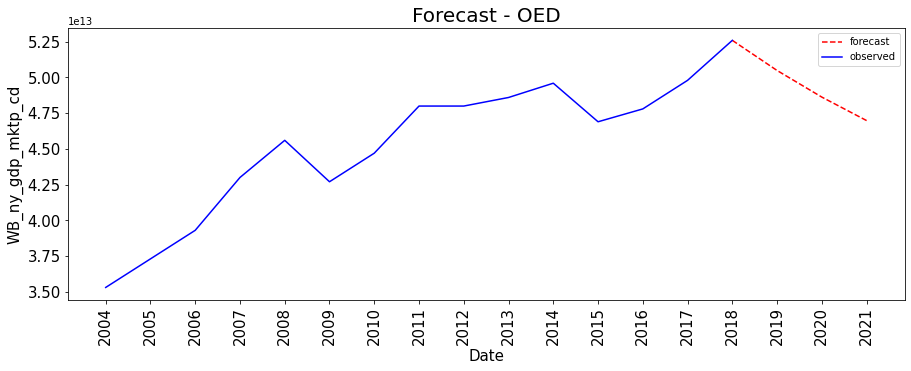

In [194]:
fig7 = pickle.load(open('FigureObject7.fig.pickle', 'rb'))